# county diversity diagnostics

I calculated diversity using the five-group measure found in Bellman et al., as well as a four-group measure grouping non-hispanic Asians in the 'other' category, as well as a three-group measure that completly excludes NH Asian and 'other' from all calculations.

Look at the range of values for the share of each group in counties based on population change 1990 and 2010

In [1]:
from pysqlite2 import dbapi2 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

/home/eric/anaconda2/envs/geo/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT 
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*
FROM nhgis_pop_race_norm_90_10 AS A
JOIN county_diversity AS B
    ON A.GISJOIN = B.GISJOIN
;
'''

df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
len(df)

3143

In [3]:
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT 
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*,
C.metro,
C.econdep
FROM nhgis_pop_race_norm_90_10 AS A
JOIN county_diversity AS B
    ON A.GISJOIN = B.GISJOIN
JOIN usda_typology_2004 AS C 
    ON  A.STATEA || A.COUNTYA = C.FIPSTXT
;
'''

df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
len(df)

3138

In [4]:
# merge with census regions
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT A.gisjoin, B.name AS region
FROM us_county_2010 AS A, census_regions_10 AS B
WHERE ST_Contains(B.geometry, ST_Centroid(A.geometry))
AND A.ROWID IN (SELECT ROWID FROM SpatialIndex
    WHERE f_table_name = 'us_county_2010' AND search_frame = B.geometry )
;
'''

df2 = pd.read_sql(qry, con, index_col='gisjoin')
con.close()
df = pd.merge(df, df2, left_index=True, right_index=True)
print len(df)

3131


In [5]:
# create categories for pop change 2000 to 2010
# calc pop change in each decade
df['ppctchg_0010'] = ( df['pop10'] - df['pop00'] ) * 1.0 / df['pop00'] * 100
df['ppctchg_9000'] = ( df['pop00'] - df['pop90'] ) * 1.0 / df['pop90'] * 100
# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0010'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0010'] < 5) & (df['ppctchg_0010'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0010'] < 0, 'growth_cat'] = 'shrinking'
# growth categories 1990-2000
df['growth_cat_90s'] = 0
df.loc[df['ppctchg_9000'] >= 5, 'growth_cat_90s'] = 'growing'
df.loc[(df['ppctchg_9000'] < 5) & (df['ppctchg_9000'] >= 0 ), 'growth_cat_90s'] = 'stable'
df.loc[df['ppctchg_9000'] < 0, 'growth_cat_90s'] = 'shrinking'
# xtab counties between 1990s and 2000s in terms of pop change category
pd.crosstab(df['growth_cat_90s'], df['growth_cat'], margins=True)

growth_cat,growing,shrinking,stable,All
growth_cat_90s,,,,
growing,1193,292,458,1943
shrinking,47,531,99,677
stable,57,270,184,511
All,1297,1093,741,3131


We lose five counties joining NHGIS time series tables to 2004 USDA typology tables.

We lost 8 counties from the NHGIS time series tables in my current spatial join to census regions. Create separate script to iteratively generate negative buffers for each county so they are fully contained in census region layer. Using county geom centroids puts some of them outside region.

Text(0.5,1,u'2000-2010')

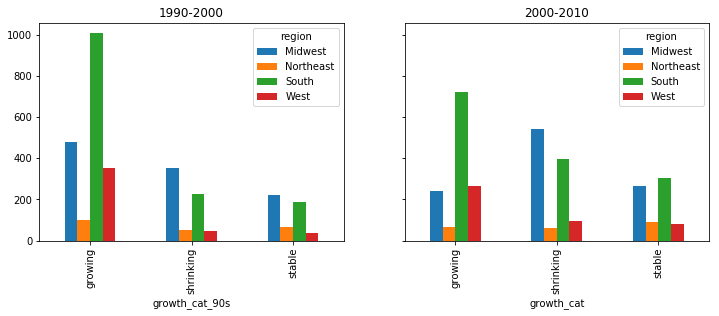

In [6]:
# how many loss counties by region?
w = 12
h = 4
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

df.groupby(['growth_cat_90s', 'region']).size().unstack().plot(kind='bar', ax=ax1)
df.groupby(['growth_cat', 'region']).size().unstack().plot(kind='bar', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

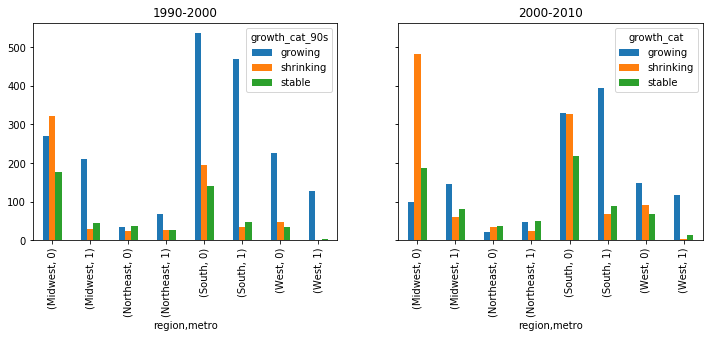

In [7]:
# group by region and metro status
# 1 = metro
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
df.groupby(['region', 'metro', 'growth_cat_90s']).size().unstack().plot(kind='bar', ax=ax1)
df.groupby(['region', 'metro', 'growth_cat']).size().unstack().plot(kind='bar', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

## economic base for shrinking counties 

In [8]:
# add labels for usda 2004 county typology codes
df['econdep_lbl'] = None
df.loc[df['econdep']==1, 'econdep_lbl'] = 'farming'
df.loc[df['econdep']==2, 'econdep_lbl'] = 'mining'
df.loc[df['econdep']==3, 'econdep_lbl'] = 'manufac'
df.loc[df['econdep']==4, 'econdep_lbl'] = 'govt'
df.loc[df['econdep']==5, 'econdep_lbl'] = 'services'
df.loc[df['econdep']==6, 'econdep_lbl'] = 'nonspec'

Text(0.5,1,u'2000-2010')

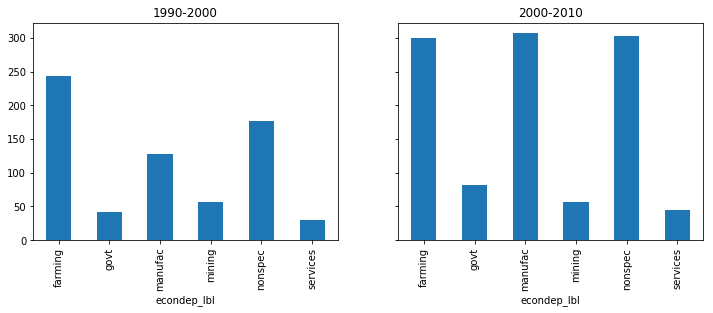

In [9]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
df.loc[df['growth_cat_90s']=='shrinking'].groupby('econdep_lbl').size().plot(kind='bar', ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby('econdep_lbl').size().plot(kind='bar', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

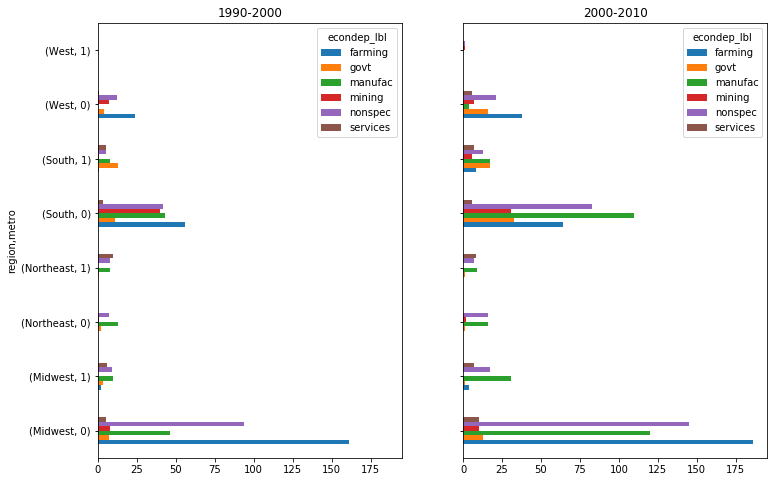

In [10]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,8))
df.loc[df['growth_cat_90s']=='shrinking'].groupby(['region', 'metro', 'econdep_lbl']).size().unstack().plot(kind='barh', ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby(['region', 'metro', 'econdep_lbl']).size().unstack().plot(kind='barh', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

## distribution of race/ethnicity in shrinking counties

(0.0, 1.0, 0.0, 1.0)

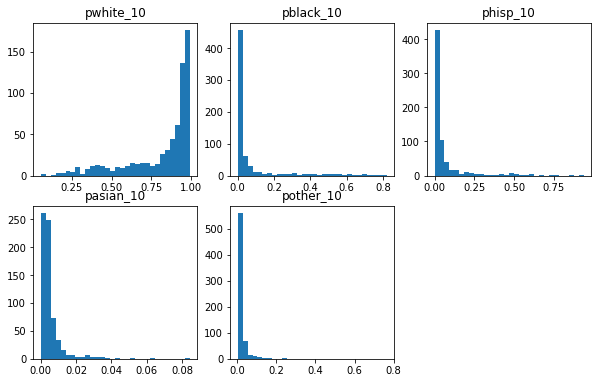

In [11]:
# look at share of each of the five groups in each pop change category in each decade
# 1990 - 2000
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 10*.618))

lst = [ (ax1, 'pwhite_10'), (ax2, 'pblack_10'), (ax3, 'phisp_10'), (ax4, 'pasian_10'), (ax5, 'pother_10') ]

for a, b in lst:
    df.loc[df['growth_cat_90s']=='shrinking'][b].hist(ax=a, bins=30, grid=False)
    a.set_title(b)
ax6.axis('off')

(0.0, 1.0, 0.0, 1.0)

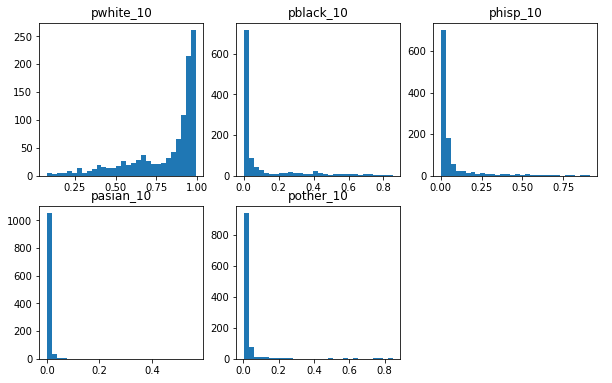

In [12]:
# look at share of each of the five groups in each pop change category in each decade
# 2000 - 2010
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 10*.618))

lst = [ (ax1, 'pwhite_10'), (ax2, 'pblack_10'), (ax3, 'phisp_10'), (ax4, 'pasian_10'), (ax5, 'pother_10') ]

for a, b in lst:
    df.loc[df['growth_cat']=='shrinking'][b].hist(ax=a, bins=30, grid=False)
    a.set_title(b)
ax6.axis('off')

(0.0, 1.0, 0.0, 1.0)

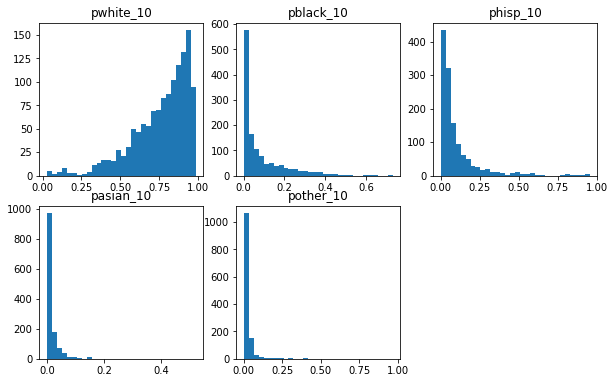

In [13]:
# how does this compare to growing counties?
# 2000 - 2010
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(10, 10*.618))

lst = [ (ax1, 'pwhite_10'), (ax2, 'pblack_10'), (ax3, 'phisp_10'), (ax4, 'pasian_10'), (ax5, 'pother_10') ]

for a, b in lst:
    df.loc[df['growth_cat']=='growing'][b].hist(ax=a, bins=30, grid=False)
    a.set_title(b)
ax6.axis('off')

## changes in diversity in each decade

Text(0.5,1,u'2000-2010')

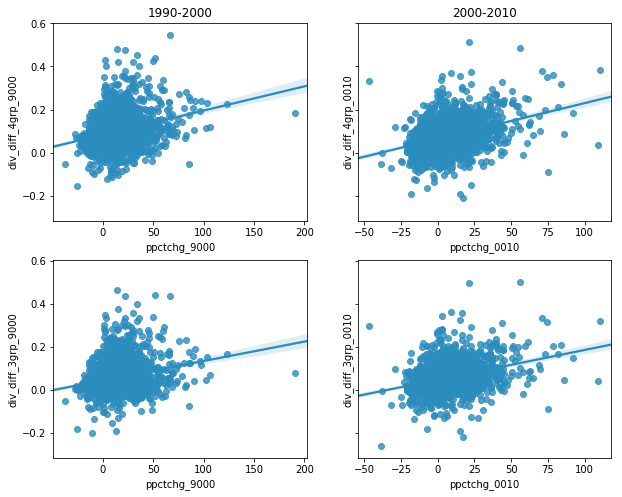

In [14]:
# plot difference in diversity score against percent pop change for both periods
# first row shows change in 4 group diversity
# second row shows change in 3 group diversity

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,8))

df['div_diff_4grp_9000'] = df['diversity_4grp_00'] - df['diversity_4grp_90']
df['div_diff_4grp_0010'] = df['diversity_4grp_10'] - df['diversity_4grp_00']

df['div_diff_3grp_9000'] = df['diversity_3grp_00'] - df['diversity_3grp_90']
df['div_diff_3grp_0010'] = df['diversity_3grp_10'] - df['diversity_3grp_00']

# df.plot.scatter('ppctchg_9000', 'div_diff_9000', ax=ax1)
# df.plot.scatter('ppctchg_0010', 'div_diff_0010', ax=ax2)
sns.regplot('ppctchg_9000', 'div_diff_4grp_9000', df, ax=ax1, color='#2b8cbe')
sns.regplot('ppctchg_0010', 'div_diff_4grp_0010', df, ax=ax2, color='#2b8cbe')
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

sns.regplot('ppctchg_9000', 'div_diff_3grp_9000', df, ax=ax3, color='#2b8cbe')
sns.regplot('ppctchg_0010', 'div_diff_3grp_0010', df, ax=ax4, color='#2b8cbe')
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

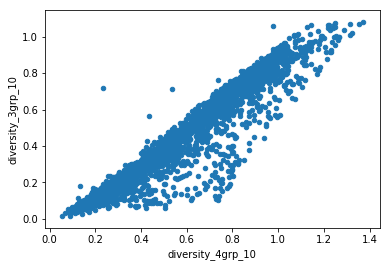

In [15]:
# plot 3 group diversity against 4 group diversity
df.plot.scatter('diversity_4grp_10', 'diversity_3grp_10')

3 group diversity pulls down relative to 4 group diversity particularly in counties w/ large native american populations 

Text(0.5,1,u'2000-2010')

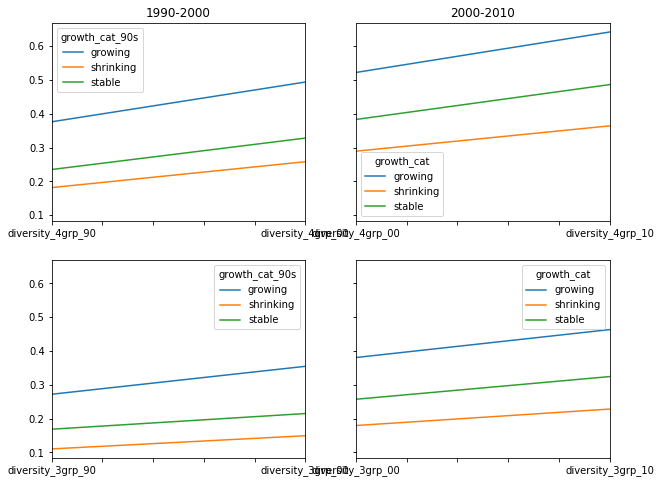

In [16]:
# plot change in median diversity across periods
# first row shows change in 4 group diversity
# second row shows change in 3 group diversity

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,8))
cols1 = ['diversity_4grp_90', 'diversity_4grp_00']
cols2 = ['diversity_4grp_00', 'diversity_4grp_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

cols1 = ['diversity_3grp_90', 'diversity_3grp_00']
cols2 = ['diversity_3grp_00', 'diversity_3grp_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax3)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax4)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

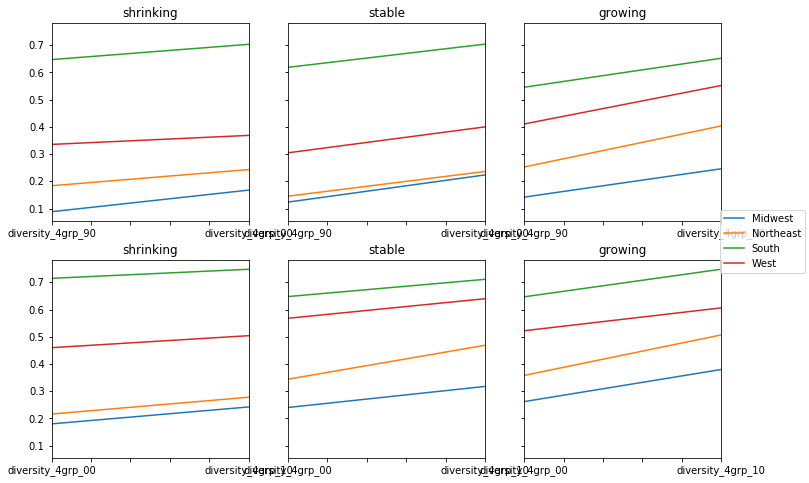

In [17]:
# show change by region
# first row shows change by growth cat and region 1990 - 2000
# second row shows same data for 2000 - 2010

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))

cols1 = ['diversity_4grp_90', 'diversity_4grp_00']
cols2 = ['diversity_4grp_00', 'diversity_4grp_10']

lst = [ (ax1, 'shrinking'), (ax2, 'stable'), (ax3, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat_90s']==b].groupby('region')[cols1].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)

lst = [ (ax4, 'shrinking'), (ax5, 'stable'), (ax6, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat']==b].groupby('region')[cols2].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

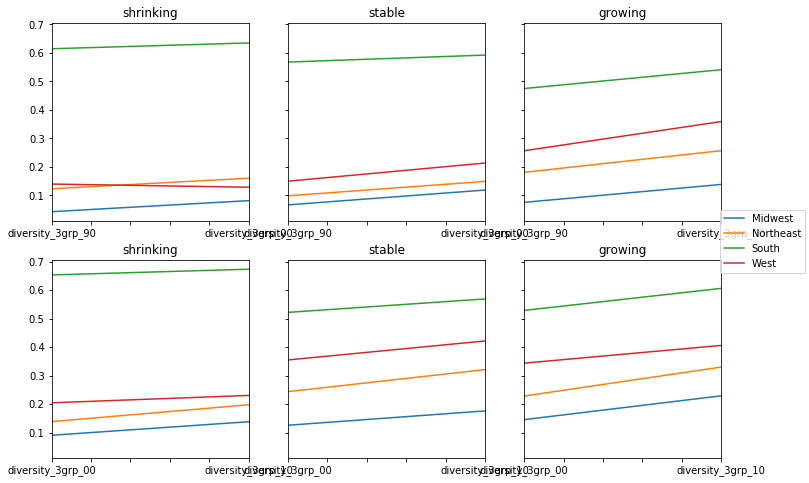

In [18]:
# 3 group diversity

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))

cols1 = ['diversity_3grp_90', 'diversity_3grp_00']
cols2 = ['diversity_3grp_00', 'diversity_3grp_10']

lst = [ (ax1, 'shrinking'), (ax2, 'stable'), (ax3, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat_90s']==b].groupby('region')[cols1].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)

lst = [ (ax4, 'shrinking'), (ax5, 'stable'), (ax6, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat']==b].groupby('region')[cols2].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

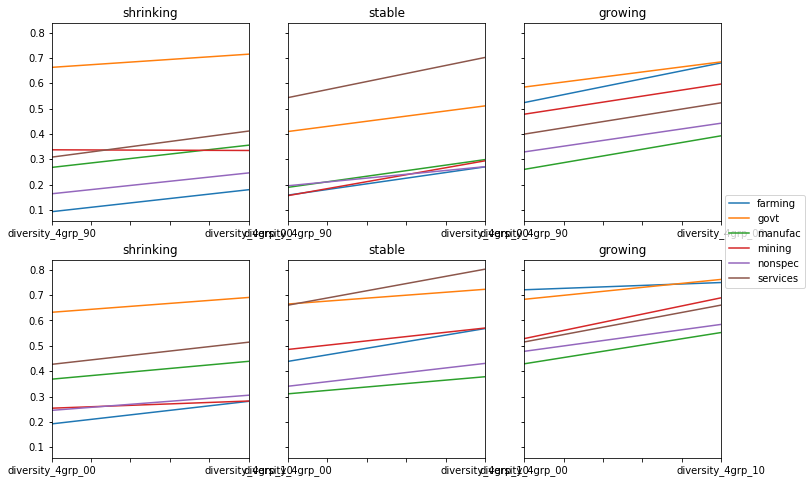

In [19]:
# show change by economic dependence
# first row shows change by growth cat and econdep 1990 - 2000
# second row shows same data for 2000 - 2010

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))

cols1 = ['diversity_4grp_90', 'diversity_4grp_00']
cols2 = ['diversity_4grp_00', 'diversity_4grp_10']

lst = [ (ax1, 'shrinking'), (ax2, 'stable'), (ax3, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat_90s']==b].groupby('econdep_lbl')[cols1].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)

lst = [ (ax4, 'shrinking'), (ax5, 'stable'), (ax6, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat']==b].groupby('econdep_lbl')[cols2].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

## regression analysis

__DV:__ diff in diversity 2000-2010. Use 4-group diversity measure. Investigate other diversity measures.

initial IVs to test, begining w/ bivariate OLS regression

__IVS:__

* pct pop change 2000-2010
* initial pop
* initial diversity
* region
* state
* metro status

In [20]:
# calc change in diversity as pct change, not diff
df['div_pctchg_4grp_0010'] = ( df['diversity_4grp_10'] - df['diversity_4grp_00'] ) / df['diversity_4grp_00'] * 100

df['pwhite_diff_0010'] = df['pwhite_10'] - df['pwhite_00']

# df.plot.scatter('div_diff_4grp_0010', 'div_pctchg_4grp_0010')
df.diff_pwhite_0010.hist(bins=20)

AttributeError: 'DataFrame' object has no attribute 'diff_pwhite_0010'

In [ ]:
df.columns.tolist()

In [ ]:
m = 'div_diff_4grp_0010 ~ ppctchg_0010'
results = smf.ols(m, data=df).fit(cov_type='HC3')
print results.summary()

In [ ]:
dummy_regions = pd.get_dummies(df['region'], prefix='region')
print dummy_regions.head()

In [ ]:
df['pop00_ln'] = np.log(df['pop00'])

In [ ]:
cols_to_keep = ['div_diff_4grp_0010', 'ppctchg_0010', 'pop00_ln', 'pwhite_00']
data = df[cols_to_keep].join(dummy_regions.loc[:, 'region_Northeast':])
data.head()

In [ ]:
data['intercept'] = 1.0

train_cols = data.columns[1:]

In [ ]:
# m = 'div_diff_4grp_0010 ~ ppctchg_0010 + np.log(pop00) + region + pwhite_00'

results = sm.OLS(data['div_diff_4grp_0010'], data[train_cols]).fit(cov_type='HC3')

print results.summary()

In [ ]:
m = 'div_diff_4grp_0010 ~ ppctchg_0010 + np.log(pop00) + region + pwhite_00'

results = smf.ols(m, data=df).fit(cov_type='HC3')

print results.summary()

In [ ]:
# create dataframe of values based on model results

def cartesian(arrays, out=None):

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [ ]:
pop_chgs = np.linspace(data['ppctchg_0010'].min(), data['ppctchg_0010'].max(), 10)
print pop_chgs

pct_whites = np.linspace(data['pwhite_00'].min(), data['pwhite_00'].max(), 10)
print pct_whites

In [ ]:
np.log(df.loc[df['growth_cat']=='shrinking']['pop00'].median())

In [ ]:
np.log(df.loc[df['growth_cat']=='shrinking']['pwhite_00'].median())

In [ ]:
# enumerate all possibilities
combos = pd.DataFrame(cartesian([pop_chgs, [-0.067202844496328198], [1, 2, 3, 4], [ 1. ], [9.4541489237339764]]))

In [ ]:
# recreate the dummy variables
combos.columns = ['ppctchg_0010', 'pwhite_00', 'region', 'intercept', 'pop00_ln']
combos.head()

In [ ]:
# recreate the dummy variables
dummy_ranks = pd.get_dummies(combos['region'], prefix='region')
dummy_ranks.columns = ['region_Midwest', 'region_Northeast', 'region_South', 'region_West']

In [ ]:
# keep only what we need for making predictions
cols_to_keep = ['ppctchg_0010', 'pwhite_00', 'region', 'intercept', 'pop00_ln']
combos = combos[cols_to_keep].join(dummy_ranks.loc[:, 'region_Northeast':])

In [ ]:
combos.head()

In [ ]:
# make predictions on the enumerated dataset
combos['dif_div_pred'] = results.predict(combos[train_cols])

In [ ]:
combos.head()

In [ ]:
grouped = pd.pivot_table(combos, values=['dif_div_pred'], index=['ppctchg_0010', 'region'], aggfunc=np.mean )

print grouped.head()

In [ ]:

colors = 'rbgyrbgy'
for col in combos.region.unique():
    plt_data = grouped.loc[grouped.index.get_level_values(1)==col]
    plt.plot(plt_data.index.get_level_values(0), plt_data['dif_div_pred'], color=colors[int(col)])
    
plt.legend(['Midwest', 'Northeast', 'West', 'South'], loc='upper left', title='region')
plt.xlabel('pct pop change 2000-2010')
plt.ylabel('diff in diversity score 2000-2010')
plt.title('predicted values')